In [ ]:
import numpy as np
import pandas as pd
data = pd.read_csv('./data/weatherHistory.csv')

data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)
data['Date'] = data['Formatted Date'].dt.date

data_grouped = data.groupby('Date').agg({
    'Summary': lambda x: x.mode()[0],
    'Precip Type': 'first',
    'Temperature (C)': 'median', 
    # 'Apparent Temperature (C)': 'median',
    # 'Humidity': 'mean',
    'Wind Speed (km/h)': 'mean',
    # 'Wind Bearing (degrees)': 'mean',
    'Visibility (km)': 'mean',
    'Loud Cover': 'mean',
    # 'Pressure (millibars)': 'mean',
    'Daily Summary': lambda x: x.mode()[0],
}).reset_index()

data_grouped['Temperature (C)'] = data_grouped['Temperature (C)'].apply(lambda x: int(x))
data_grouped['Apparent Temperature (C)'] = data_grouped['Apparent Temperature (C)'].apply(lambda x: int(x))


data_grouped['Humidity_discrete'] = pd.cut(data['Humidity'], bins=3, labels=['Low', 'Medium', 'High'])
# data_grouped['WindSpeed_discrete'] = pd.cut(data['Wind Speed (km/h)'], bins=3, labels=['Low', 'Medium', 'High'])
# data_grouped['Pressure_discrete'] = pd.cut(data['Pressure (millibars)'], bins=4, labels=['Low', 'Medium', 'High', 'Very High'])
data_grouped['Visibility_discrete'] = pd.cut(data['Visibility (km)'], bins=3, labels=['Low', 'Medium', 'High'])

temp_min = data_grouped['Temperature (C)'].min()
temp_max = data_grouped['Temperature (C)'].max()
bins = np.arange(temp_min, temp_max + 2, 2)

data_grouped['Temperature_discrete'] = pd.cut(data_grouped['Temperature (C)'], bins=bins, labels=[f'{x}-{x+2}' for x in bins[:-1]])

X = data_grouped[['Date', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)', 'Precip Type']]
Y = data_grouped[[ 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Summary', 'Visibility (km)' ]]

In [ ]:
# Créer des fenêtres de 3 jours précédents et 3 jours suivants
def create_sequences(data_grouped, window_size=3):
    sequences = []
    for i in range(len(data_grouped) - 2 * window_size):
        input_seq = data_grouped.iloc[i:i + window_size]  # Les 3 jours précédents
        output_seq = data_grouped.iloc[i + window_size:i + 2 * window_size]  # Les 3 jours suivants
        sequences.append((input_seq, output_seq))
    return sequences

# Appliquer cette fonction pour obtenir nos séquences
sequences = create_sequences(data_grouped, window_size=3)

# Exemple d'une séquence
print(sequences[0])  # Affiche une séquence pour visualiser


In [4]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

b = gum.BayesNet('test')
b.addArc()

gnb.showBN(b)


TypeError: list indices must be integers or slices, not str

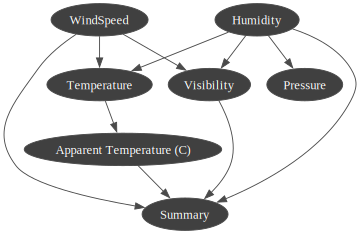

In [25]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

# Créer un modèle de réseau bayésien
bn = gum.BayesNet('WeatherPrediction')

# Ajouter des variables (nodes) pour chaque paramètre météorologique
temp = bn.add(gum.LabelizedVariable('Temperature', 'Température', 3))  # Exemple avec 3 intervalles
hum = bn.add(gum.LabelizedVariable('Humidity', 'Humidité', 3))
wind = bn.add(gum.LabelizedVariable('WindSpeed', 'Vitesse du vent', 3))
visib = bn.add(gum.LabelizedVariable('Visibility', 'Visibilité', 3))
app_temp = bn.add(gum.LabelizedVariable('Apparent Temperature (C)', 'Température apparente', 3))
summary = bn.add(gum.LabelizedVariable('Summary', 'Résumé', 3))


# Ajouter des arcs (dépendances conditionnelles) entre les variables
  # Température influence l'humidité # Température influence la vitesse du vent
bn.addArc(wind, temp)  # Humidité influence la pression atmosphérique
bn.addArc(wind, visib)  # Vitesse du vent influence la visibilité
bn.addArc(hum, visib)  # Humidité influence la visibilité
bn.addArc(hum, temp)
bn.addArc(hum, summary)
bn.addArc(wind, summary)
bn.addArc(temp, app_temp)
bn.addArc(app_temp, summary)
bn.addArc(visib, summary)

# Afficher le réseau
gnb.showBN(bn)



In [23]:
import pyAgrum as gum

bn = gum.BayesNet('Weather Prediction')

bn.add(gum.LabelizedVariable('Temperature_discrete', 'Temperature', data_grouped['Temperature_discrete'].cat.categories.astype(str).tolist()))
bn.add(gum.LabelizedVariable('Humidity_discrete', 'Humidity', data_grouped['Humidity_discrete'].cat.categories.tolist()))
bn.add(gum.LabelizedVariable('WindSpeed_discrete', 'WindSpeed', data_grouped['WindSpeed_discrete'].cat.categories.tolist()))
bn.add(gum.LabelizedVariable('Pressure_discrete', 'Pressure', data_grouped['Pressure_discrete'].cat.categories.tolist()))
bn.add(gum.LabelizedVariable('Summary', 'Summary', data_grouped['Summary'].unique()))
bn.add(gum.LabelizedVariable('Visibility', 'Visibility', data_grouped['Visibility_discrete'].unique()))

# Ajouter les arcs (relations) entre les nœuds
bn.addArc('Temperature_discrete', 'Summary')
bn.addArc('Humidity_discrete', 'Summary')
bn.addArc('WindSpeed_discrete', 'Summary')
bn.addArc('Pressure_discrete', 'Summary')
bn.addArc('Visibility', 'Summary')

for var in bn.names():
    parents = bn.variable(var).parents()
    if parents:  # Vérifie si la variable a des parents
        # Créer la table de probabilités conditionnelles
        cpt = gum.Potential()
        cpt.create(bn.variable(var), parents)

        # Calculer les fréquences
        counts = data_grouped.groupby(parents + [var]).size()
        for index, count in counts.items():
            cpt[index] = count

        # Normaliser les fréquences pour obtenir des probabilités
        cpt.normalize()

        # Ajouter la CPT au modèle
        bn.setConditionalDistribution(var, cpt)

print(bn)


AttributeError: 'DiscreteVariable' object has no attribute 'parents'